In [1]:
!git clone https://github.com/teddyalexandre/Laplace-Redux.git

Cloning into 'Laplace-Redux'...


In [24]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch
import matplotlib.pyplot as plt

from laplace import Laplace, marglik_training

from Laplace.examples.helper.dataloaders import get_sinusoid_example, get_my_func_example
from Laplace.examples.helper.util import plot_regression
from tqdm import tqdm
torch.manual_seed(711)
# sample toy data example
sigma = 0.5
#my_func = lambda x: -(torch.sin((x-5))+0.1*(x-5))**2+5
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3)

#X_train, y_train, train_loader, X_test = get_my_func_example(my_func, -10, 20, n_data=500, sigma_noise=sigma, batch_size=500)

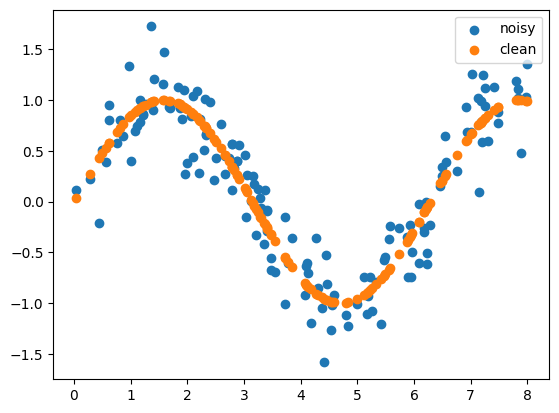

In [26]:
plt.scatter(X_train, y_train, label="noisy")
plt.scatter(X_train, torch.sin(X_train), label="clean")
plt.legend()
plt.show()

# simple example of uncertainty quantification

Defining a mini NN

In [27]:
def get_model():
    torch.manual_seed(711)
    # 1->50 -> tanh -> 50 -> 1
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

Fit to sine. We obtain a MAP estimator.

In [28]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


n_epochs = 1000
for i in tqdm(range(n_epochs)):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

100%|██████████| 1000/1000 [00:02<00:00, 349.28it/s]


In [29]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')

# fitting LA to the parameters of the model
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [56]:
type(la)

laplace.baselaplace.FullLaplace

In [54]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)
pred_mlp = model(X_test).detach().cpu().numpy()

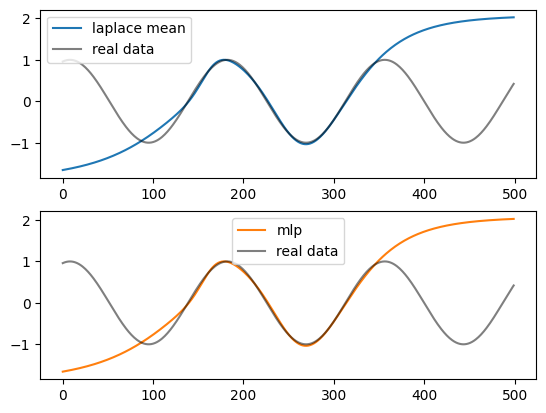

In [55]:
plt.subplot(2, 1, 1)
plt.plot(f_mu, label="laplace mean")
plt.plot(np.sin(x), label="real data", c="black", alpha=0.5)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(pred_mlp, label="mlp", c= "#ff7f0e")
plt.plot(np.sin(x), label="real data", c='black', alpha=0.5)
plt.legend()
plt.show()

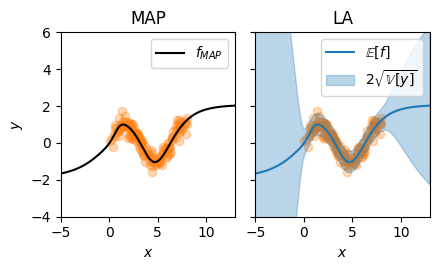

In [53]:
plot_regression(X_train, y_train, x, f_mu, pred_std)